# Manipulating TaiChung DE Plant PV Power , Weather and Solar Irriandance.

Data from TaiChung DE PV plant.

Collect 2016/01/01-2017/12/31.

Time frequcy: 1 hour.

Add WUQI weather data.

Collect from : http://e-service.cwb.gov.tw/HistoryDataQuery/DayDataController.do?command=viewMain&station=467770&stname=%25E6%25A2%25A7%25E6%25A3%25B2&datepicker=2016-01-01
        
Use: http://localhost:8888/notebooks/interview/Interview/Collect_WUQI_CWB_Data.ipynb

Add solar irradiance.

In [1]:
# import library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# quick look data
power = pd.read_csv('data\\power_no_outlier.csv', parse_dates=['Date'], index_col='Date', encoding='utf-8-sig')
weather = pd.read_csv('data\\weather.csv', parse_dates=['Date'], index_col='Date', encoding='utf-8-sig')
irradiance = pd.read_csv('data\\Solar_Irradiance.csv', parse_dates=['Date'], index_col='Date', encoding='utf-8-sig')
print(weather.head(12))
print(weather.info())
print(irradiance.head(12))
print(irradiance.info())

                     StnPres  SeaPres  Temperature  Td dew point  RH   WS  \
Date                                                                        
2016-01-01 01:00:00   1021.7   1024.9         15.1          10.8  75  3.8   
2016-01-01 02:00:00   1021.5   1024.7         15.0          10.8  76  2.4   
2016-01-01 03:00:00   1021.0   1024.2         14.9          10.7  76  3.7   
2016-01-01 04:00:00   1021.1   1024.3         14.9          10.9  77  3.9   
2016-01-01 05:00:00   1021.0   1024.2         14.9          11.1  78  3.7   
2016-01-01 06:00:00   1021.4   1024.6         14.8          11.3  80  3.0   
2016-01-01 07:00:00   1022.1   1025.3         14.6          11.4  81  2.9   
2016-01-01 08:00:00   1022.7   1025.9         15.8          12.1  79  3.0   
2016-01-01 09:00:00   1023.2   1026.4         18.3          13.1  72  2.5   
2016-01-01 10:00:00   1023.0   1026.2         19.2          13.3  69  5.5   
2016-01-01 11:00:00   1022.5   1025.7         20.1          14.4  70  5.1   

We have to clean '...' .

According to Dtype, WD and Precp mixed non-value data.

WD: int

Precp: float

In [3]:
# ... → nan
def replace_dot(df):
    return np.where(df == '...', np.nan, df)

weather = weather.apply(replace_dot)

# convert to numeric
weather['WD']= pd.to_numeric(weather['WD'], errors='coerce', downcast='integer')
weather['Precp'] = pd.to_numeric(weather['Precp'], errors='coerce', downcast='float')
# fill nan
weather['WD'].interpolate(method='linear',inplace=True)
weather['Precp'].interpolate(method='linear',inplace=True)
print(weather.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2016-01-01 01:00:00 to 2018-01-01 00:00:00
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   StnPres       17544 non-null  float64
 1   SeaPres       17544 non-null  float64
 2   Temperature   17544 non-null  float64
 3   Td dew point  17544 non-null  float64
 4   RH            17544 non-null  float64
 5   WS            17544 non-null  float64
 6   WD            17544 non-null  float64
 7   WSGust        17544 non-null  float64
 8   WDGust        17544 non-null  float64
 9   Precp         17544 non-null  float32
 10  PrecpHour     17544 non-null  float64
 11  SunShine      10234 non-null  object 
 12  GloblRad      17544 non-null  float64
 13  Visb          4387 non-null   object 
 14  UVI           0 non-null      object 
 15  Cloud Amount  4387 non-null   object 
dtypes: float32(1), float64(11), object(4)
memory usage: 2.2+ MB
None


Clearly , UVI can drop.

Visb, Cloud Amout just has 25% data, we drop too.

SunShine fill zero.

In [4]:
# drop visb, UVI, Cloud Amout
weather.drop(columns=['Visb', 'UVI', 'Cloud Amount'], inplace=True)
weather['SunShine'].fillna(0, inplace=True)
# merge 3 dataframe
data = power[['power(KWH)_replaced']].merge(weather, on='Date')
data = data.merge(irradiance, on='Date', how='left')
data['Solar Irradiance'].fillna(0, inplace=True)
print(data.info())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2016-01-01 01:00:00 to 2018-01-01 00:00:00
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   power(KWH)_replaced  17544 non-null  float64
 1   StnPres              17544 non-null  float64
 2   SeaPres              17544 non-null  float64
 3   Temperature          17544 non-null  float64
 4   Td dew point         17544 non-null  float64
 5   RH                   17544 non-null  float64
 6   WS                   17544 non-null  float64
 7   WD                   17544 non-null  float64
 8   WSGust               17544 non-null  float64
 9   WDGust               17544 non-null  float64
 10  Precp                17544 non-null  float32
 11  PrecpHour            17544 non-null  float64
 12  SunShine             17544 non-null  object 
 13  GloblRad             17544 non-null  float64
 14  Solar Irradiance     17544 non-null  float64
dtypes

According to Dtype, SunShine mixed non-value data.

       power(KWH)_replaced       StnPres       SeaPres   Temperature  \
count         17544.000000  17544.000000  17544.000000  17544.000000   
mean            209.314495   1010.061639   1013.170366     23.590532   
std             321.357382      6.035039      6.102778      5.634428   
min               0.000000    957.900000    960.800000      4.400000   
25%               0.000000   1006.000000   1009.100000     19.000000   
50%               0.000000   1009.600000   1012.700000     24.600000   
75%             348.000000   1014.300000   1017.500000     28.300000   
max            1719.500000   1031.400000   1034.800000     34.700000   

       Td dew point            RH            WS            WD        WSGust  \
count  17544.000000  17544.000000  17544.000000  17544.000000  17544.000000   
mean      19.328471     77.559451      4.352160    224.331110      8.955877   
std        5.629000      9.069971      2.759431    132.654749      5.447381   
min       -5.100000     30.000000  

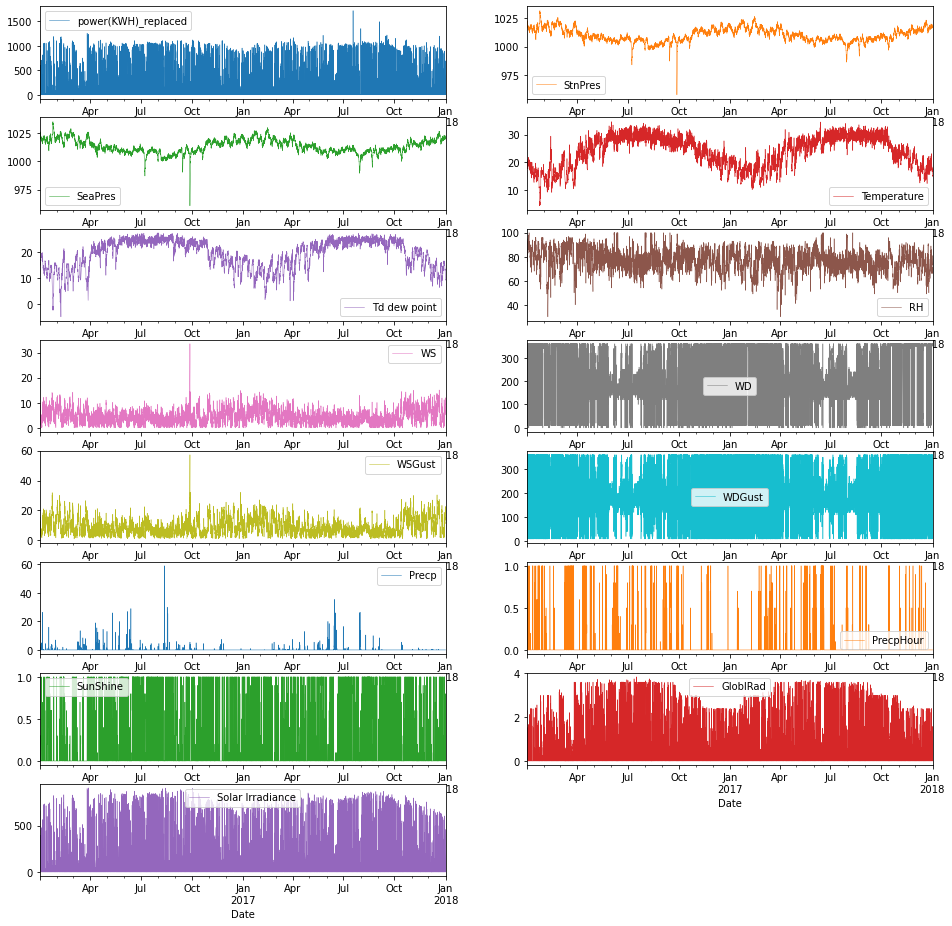

In [5]:
data['SunShine'] = pd.to_numeric(data['SunShine'], errors='coerce', downcast='float')
data['SunShine'].interpolate(method='linear',inplace=True)
print(data.describe())
# visualizing data
data.plot(subplots=True, linewidth=0.5, layout=(8, 2), figsize=(16, 16),
          sharex=False, sharey=False)
plt.show()


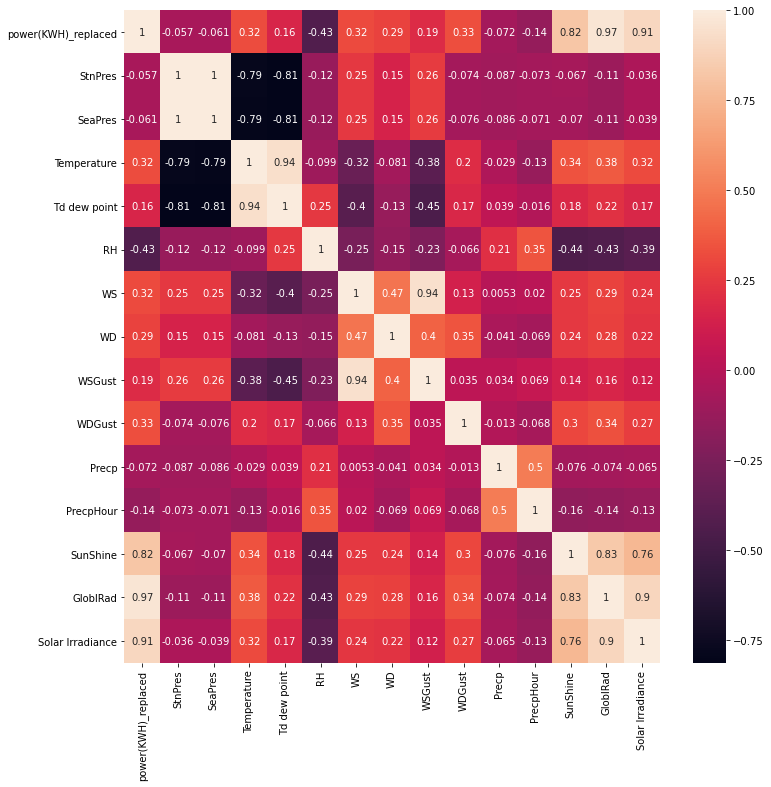

In [6]:
# Computing Correlation Matrices
corr_mat = data.corr(method='pearson')
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(corr_mat, annot=True)
plt.show()


High degree : abs(correlation) > 0.5

Moderate degree: 0.49 > abs(correlation) > 0.3

Low degree: 0.29 > abs(correlation)

We keep high degree data.

In [7]:
data_high = data[['power(KWH)_replaced', 'SunShine', 'GloblRad', 'Solar Irradiance']]
# save data
data_high.to_csv('data\\Taichung_Power_Sunshine_Irradiance.csv', encoding='utf-8-sig')